In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR[:-3] not in sys.path:
    sys.path.append(LIB_DIR[:-3])

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
import scipy as sp

In [3]:
RESULTS_DIR = os.path.join(BASE_PATH, 'results')

In [4]:
from lib import fca_interp as fcai
from lib.utils_ import powerset, sparse_unique_columns
from importlib import reload

In [5]:
from importlib import reload

In [6]:
from copy import copy, deepcopy

# Load Data

In [7]:
data_dict = {}

## Big DataSet

In [8]:
adult_ds = pd.read_csv(DATASETS_DIR+'/adult/adult.data', header=None)
fs = ['age','workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
      'relationship', 'race', 'sex', 'capital-gain', 'capital-loss','hours-per-week','native-country',
      'y']
adult_ds.columns = fs
adult_ds['y_bin'] = (adult_ds['y']==' >50K').astype(int)
cat_feats = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
y_feat = 'y_bin'
train_feats = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-loss','native-country']
adult_ds.drop(train_feats,1)

print(adult_ds.shape)
adult_ds.head(2)

(32561, 16)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,y,y_bin
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,0


In [9]:
data_dict['adult'] = {'ds':adult_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

## Small DS

In [10]:
breast_ds = pd.read_csv(DATASETS_DIR+'/breast_cancer/breast-cancer-wisconsin.data', header=None)
fs = ['Sample_code','Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
     'Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses','Class']
breast_ds.columns = fs
breast_ds['Bare_Nuclei'] = [int(x) if x!='?' else -1 for x in breast_ds['Bare_Nuclei']]

breast_ds['y'] = (breast_ds['Class']-2)//2
train_feats = ['Clump_Thickness','Uniformity_of_Cell_Size','Uniformity_of_Cell_Shape','Marginal_Adhesion',
     'Single_Epithelial_Cell_Size','Bare_Nuclei','Bland_Chromatin','Normal_Nucleoli','Mitoses',]
cat_feats = []
y_feat = 'y'

print(breast_ds.shape)
breast_ds.head()

(699, 12)


,Sample_code,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class,y
0,1000025,5,1,1,1,2,1,3,1,1,2,0
1,1002945,5,4,4,5,7,10,3,2,1,2,0
2,1015425,3,1,1,1,2,2,3,1,1,2,0
3,1016277,6,8,8,1,3,4,3,7,1,2,0
4,1017023,4,1,1,3,2,1,3,1,1,2,0


In [11]:
data_dict['breast'] = {'ds':breast_ds, 'train_feats':train_feats, 'cat_feats':cat_feats, 'y_feat':y_feat}

# Training Trees

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [203]:
data = data_dict['breast']
ds, train_feats, cat_feats, y_feat = data['ds'], data['train_feats'], data['cat_feats'], data['y_feat']

In [204]:
X_train, X_test, y_train, y_test = train_test_split(ds[train_feats], ds[y_feat])

In [205]:
X_train_ohe = X_train.copy()
X_test_ohe = X_test.copy()
for f in cat_feats:
    for v in X_train_ohe[f].unique():
        X_train_ohe[f"{f}__{v}"] = X_train[f]==v
        X_test_ohe[f"{f}__{v}"] = X_test[f]==v
    X_train_ohe = X_train_ohe.drop(f,1)
    X_test_ohe = X_test_ohe.drop(f, 1)

In [206]:
subsample_size = 0.9

In [207]:
cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index], y_true=y_test, cat_attrs=cat_feats)
fm = fcai.FormalManager(cntx_train)

In [208]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score

In [209]:
ths = np.arange(0, 1.001, 0.01)[:]

## Random Forest Comparison

In [238]:
paths_all = None
stats = []
exts_all = []
concepts_all = []
trees = []
for n_iter in tqdm(range(100)):
    n_old_concepts = paths_all.shape[1] if paths_all is not None else 0

    np.random.seed(n_iter)
    idxs = np.random.choice(X_train.index, size=int(subsample_size*len(X_train.index)),)
    X_sub, y_sub = X_train_ohe.loc[idxs], y_train.loc[idxs]

    tree = DecisionTreeClassifier(max_depth=3)
    tree.fit(X_sub, y_sub)
    trees.append(tree)
    #paths = tree.decision_path(X_full)
    
    #paths_all = sparse_unique_columns(sp.sparse.hstack([paths_all, paths]))[0] if paths_all is not None else paths

    exts = [tuple(ext) for ext in fm._parse_tree_to_extents(tree, X_train_ohe, cntx_train.get_objs())]
    exts = [ext for ext in exts if ext not in exts_all]
    exts_all += exts
    
    concepts = []
    for ext in tqdm(exts, leave=False, disable=True):
        c = fcai.PatternStructure(cntx_train.get_objs()[list(ext)], cntx_train.get_intent(ext),
                                  metrics=fm._calc_metrics_inconcept(list(ext)))
        concepts.append(c)
    concepts_all += concepts
    for idx, c in enumerate(fm.sort_concepts(concepts_all)):
        c._idx = idx
    fm._concepts = concepts_all
    fm.construct_lattice(only_spanning_tree=True)
    preds_train = fm.predict_context(cntx_train)
    preds_test = fm.predict_context(cntx_test)
    
    preds_rf_train = np.vstack([tree.predict_proba(X_train_ohe)[:,1] for tree in trees]).mean(0).reshape(-1,1)
    preds_rf_test = np.vstack([tree.predict_proba(X_test_ohe)[:,1] for tree in trees]).mean(0).reshape(-1,1)
    
    th_f1 = ths[np.argmax([f1_score(y_train, preds) for preds in (preds_train>ths).T])]
    th_acc = ths[np.argmax([accuracy_score(y_train, preds) for preds in (preds_train>ths).T])]
    
    th_f1_rf = ths[np.argmax([f1_score(y_train, preds) for preds in (preds_rf_train>ths).T])]
    th_acc_rf = ths[np.argmax([accuracy_score(y_train, preds) for preds in (preds_rf_train>ths).T])]
        
    stat = {}
    stat['new concepts num'] = len(exts)
    stat['concepts num'] = len(exts_all)
    stat['roc auc score train'] = roc_auc_score(y_train, preds_train)
    stat['accuracy score train'] = accuracy_score(y_train, preds_train>th_acc)
    stat['f1 score train'] = f1_score(y_train, preds_train>th_f1)
    stat['roc auc score test'] = roc_auc_score(y_test, preds_test)
    stat['accuracy score test'] = accuracy_score(y_test, preds_test>th_acc)
    stat['f1 score test'] = f1_score(y_test, preds_test>th_f1)
    
    stat['roc auc score rf train'] = roc_auc_score(y_train, preds_rf_train)
    stat['accuracy score rf train'] = accuracy_score(y_train, preds_rf_train>th_acc_rf)
    stat['f1 score rf train'] = f1_score(y_train, preds_rf_train>th_f1_rf)
    stat['roc auc score rf test'] = roc_auc_score(y_test, preds_rf_test)
    stat['accuracy score rf test'] = accuracy_score(y_test, preds_rf_test>th_acc_rf)
    stat['f1 score rf test'] = f1_score(y_test, preds_rf_test>th_f1_rf)
    
    stats.append(stat)

In [239]:
stats_rf_ds = pd.concat([pd.Series(s) for s in stats],1).T

## Gradient Boosting Comparison

In [240]:
from sklearn.tree import DecisionTreeRegressor

In [241]:
from sklearn.ensemble import GradientBoostingClassifier

In [242]:
paths_all = None
stats = []
exts_all = []
concepts_all = []
trees = []
for n_iter in tqdm(range(100)):
    n_old_concepts = paths_all.shape[1] if paths_all is not None else 0

    np.random.seed(0) #n_iter)
    idxs = np.random.choice(X_train.index, size=int(subsample_size*len(X_train.index)),)
    
    if n_iter>0:
        #preds_gb = np.vstack([tree.predict(X_train) for tree in trees]).sum(0)
        y_diff = y_train-preds_train.flatten() # preds_gb
    else:
        y_diff = y_train
    
    tree = DecisionTreeRegressor(max_depth=3, random_state=0)
    tree.fit(X_train_ohe, y_diff)
    trees.append(tree)
    

    exts = [tuple(ext) for ext in fm._parse_tree_to_extents(tree, X_train_ohe, cntx_train.get_objs())]
    exts = [ext for ext in exts if ext not in exts_all]
    exts_all += exts
    
    concepts = []
    for ext in tqdm(exts, leave=False, disable=True):
        c = fcai.PatternStructure(cntx_train.get_objs()[list(ext)], cntx_train.get_intent(ext),
                                  metrics=fm._calc_metrics_inconcept(list(ext)))
        concepts.append(c)
    concepts_all += concepts
    for idx, c in enumerate(fm.sort_concepts(concepts_all)):
        c._idx = idx
    fm._concepts = concepts_all
    fm.construct_lattice(only_spanning_tree=True)
    preds_train = fm.predict_context(cntx_train)
    preds_test = fm.predict_context(cntx_test)
    
    preds_rf_train = np.vstack([tree.predict(X_train_ohe) for tree in trees]).sum(0).reshape(-1,1)
    preds_rf_test = np.vstack([tree.predict(X_test_ohe) for tree in trees]).sum(0).reshape(-1,1)
    
    th_f1 = ths[np.argmax([f1_score(y_train, preds) for preds in (preds_train>ths).T])]
    th_acc = ths[np.argmax([accuracy_score(y_train, preds) for preds in (preds_train>ths).T])]
    
    th_f1_rf = ths[np.argmax([f1_score(y_train, preds) for preds in (preds_rf_train>ths).T])]
    th_acc_rf = ths[np.argmax([accuracy_score(y_train, preds) for preds in (preds_rf_train>ths).T])]
        
    stat = {}
    stat['new concepts num'] = len(exts)
    stat['concepts num'] = len(exts_all)
    stat['roc auc score train'] = roc_auc_score(y_train, preds_train)
    stat['accuracy score train'] = accuracy_score(y_train, preds_train>th_acc)
    stat['f1 score train'] = f1_score(y_train, preds_train>th_f1)
    stat['roc auc score test'] = roc_auc_score(y_test, preds_test)
    stat['accuracy score test'] = accuracy_score(y_test, preds_test>th_acc)
    stat['f1 score test'] = f1_score(y_test, preds_test>th_f1)
    
    stat['roc auc score gb train'] = roc_auc_score(y_train, preds_rf_train)
    stat['accuracy score gb train'] = accuracy_score(y_train, preds_rf_train>th_acc_rf)
    stat['f1 score gb train'] = f1_score(y_train, preds_rf_train>th_f1_rf)
    stat['roc auc score gb test'] = roc_auc_score(y_test, preds_rf_test)
    stat['accuracy score gb test'] = accuracy_score(y_test, preds_rf_test>th_acc_rf)
    stat['f1 score gb test'] = f1_score(y_test, preds_rf_test>th_f1_rf)
    
    stats.append(stat)

In [243]:
stats_gb_ds = pd.concat([pd.Series(s) for s in stats],1).T

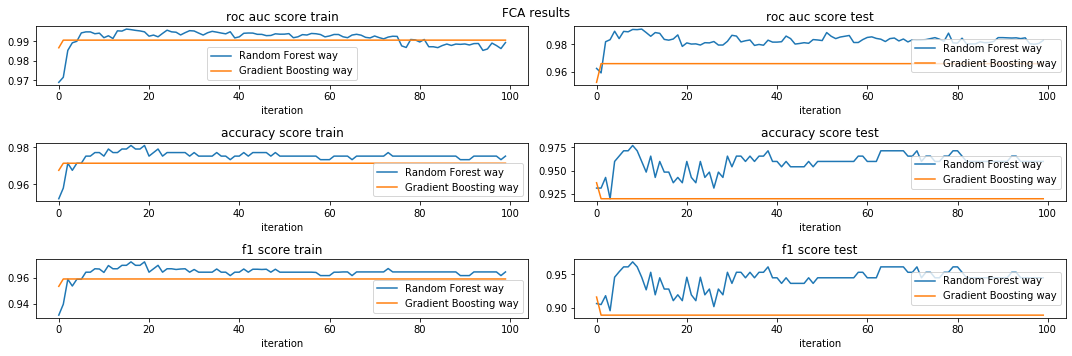

In [244]:
plt.figure(figsize=(15,5))
for idx, m in enumerate(['roc auc score', 'accuracy score','f1 score']):
    plt.subplot(3,2,2*idx+1)
    plt.plot(stats_rf_ds[f'{m} train'], label='Random Forest way')
    plt.plot(stats_gb_ds[f'{m} train'], label='Gradient Boosting way')
    plt.title(f"{m} train")
    plt.xlabel('iteration')
    plt.legend()

    plt.subplot(3,2,2*idx+2)
    plt.plot(stats_rf_ds[f'{m} test'], label='Random Forest way')
    plt.plot(stats_gb_ds[f'{m} test'], label='Gradient Boosting way')
    plt.title(f"{m} test")
    plt.xlabel('iteration')
    plt.legend(loc='right')

plt.tight_layout()
plt.suptitle('FCA results')
plt.show()

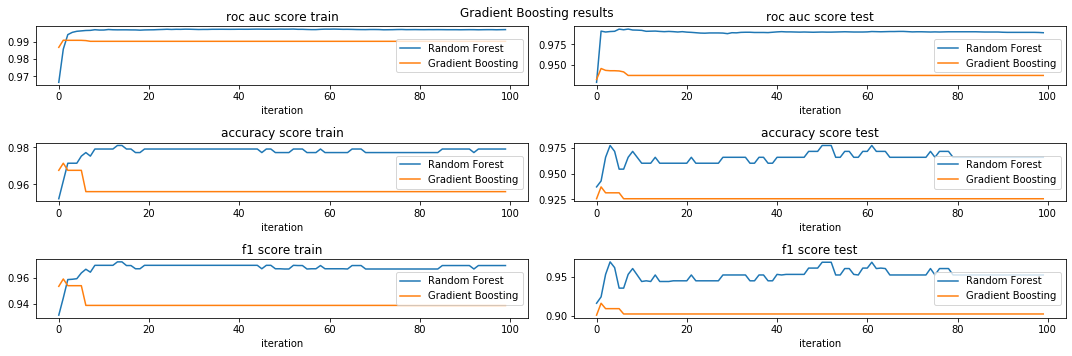

In [245]:
plt.figure(figsize=(15,5))
for idx, m in enumerate(['roc auc score', 'accuracy score','f1 score']):
    plt.subplot(3,2,2*idx+1)
    plt.plot(stats_rf_ds[f'{m} rf train'], label='Random Forest')
    plt.plot(stats_gb_ds[f'{m} gb train'], label='Gradient Boosting')
    plt.title(f"{m} train")
    plt.xlabel('iteration')
    plt.legend(loc='right')

    plt.subplot(3,2,2*idx+2)
    plt.plot(stats_rf_ds[f'{m} rf test'], label='Random Forest')
    plt.plot(stats_gb_ds[f'{m} gb test'], label='Gradient Boosting')
    plt.title(f"{m} test")
    plt.xlabel('iteration')
    plt.legend(loc='right')

plt.tight_layout()
plt.suptitle('Gradient Boosting results')
plt.show()

## Combination

In [246]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

In [247]:
paths_all = None
stats = []
exts_all = []
concepts_all = []
trees = []
for n_iter in tqdm(range(100)):
    n_old_concepts = paths_all.shape[1] if paths_all is not None else 0

    np.random.seed(0) #n_iter)
    idxs = np.random.choice(X_train.index, size=int(subsample_size*len(X_train.index)),)
    
    if n_iter>0:
        #preds_gb = np.vstack([tree.predict(X_train) for tree in trees]).sum(0)
        y_diff = y_train-preds_train.flatten() # preds_gb
    else:
        y_diff = y_train
    
    tree = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=25)
    #tree = DecisionTreeRegressor(max_depth=5, random_state=0)
    tree.fit(X_train_ohe, y_diff)
    trees.append(tree)
    

    exts = [tuple(ext) for ext in fm._parse_tree_to_extents(tree, X_train_ohe, cntx_train.get_objs())]
    exts = [ext for ext in exts if ext not in exts_all]
    exts_all += exts
    
    concepts = []
    for ext in tqdm(exts, leave=False, disable=True):
        c = fcai.PatternStructure(cntx_train.get_objs()[list(ext)], cntx_train.get_intent(ext),
                                  metrics=fm._calc_metrics_inconcept(list(ext)))
        concepts.append(c)
    concepts_all += concepts
    for idx, c in enumerate(fm.sort_concepts(concepts_all)):
        c._idx = idx
    fm._concepts = concepts_all
    fm.construct_lattice(only_spanning_tree=True)
    preds_train = fm.predict_context(cntx_train)
    preds_test = fm.predict_context(cntx_test)
    
    preds_rf_train = np.vstack([tree.predict(X_train_ohe) for tree in trees]).sum(0).reshape(-1,1)
    preds_rf_test = np.vstack([tree.predict(X_test_ohe) for tree in trees]).sum(0).reshape(-1,1)
    
    th_f1 = ths[np.argmax([f1_score(y_train, preds) for preds in (preds_train>ths).T])]
    th_acc = ths[np.argmax([accuracy_score(y_train, preds) for preds in (preds_train>ths).T])]
    
    th_f1_rf = ths[np.argmax([f1_score(y_train, preds) for preds in (preds_rf_train>ths).T])]
    th_acc_rf = ths[np.argmax([accuracy_score(y_train, preds) for preds in (preds_rf_train>ths).T])]
        
    stat = {}
    stat['new concepts num'] = len(exts)
    stat['concepts num'] = len(exts_all)
    stat['roc auc score train'] = roc_auc_score(y_train, preds_train)
    stat['accuracy score train'] = accuracy_score(y_train, preds_train>th_acc)
    stat['f1 score train'] = f1_score(y_train, preds_train>th_f1)
    stat['roc auc score test'] = roc_auc_score(y_test, preds_test)
    stat['accuracy score test'] = accuracy_score(y_test, preds_test>th_acc)
    stat['f1 score test'] = f1_score(y_test, preds_test>th_f1)
    
    stat['roc auc score gb train'] = roc_auc_score(y_train, preds_rf_train)
    stat['accuracy score gb train'] = accuracy_score(y_train, preds_rf_train>th_acc_rf)
    stat['f1 score gb train'] = f1_score(y_train, preds_rf_train>th_f1_rf)
    stat['roc auc score gb test'] = roc_auc_score(y_test, preds_rf_test)
    stat['accuracy score gb test'] = accuracy_score(y_test, preds_rf_test>th_acc_rf)
    stat['f1 score gb test'] = f1_score(y_test, preds_rf_test>th_f1_rf)
    
    stats.append(stat)

In [248]:
stats_comb_ds = pd.concat([pd.Series(s) for s in stats],1).T

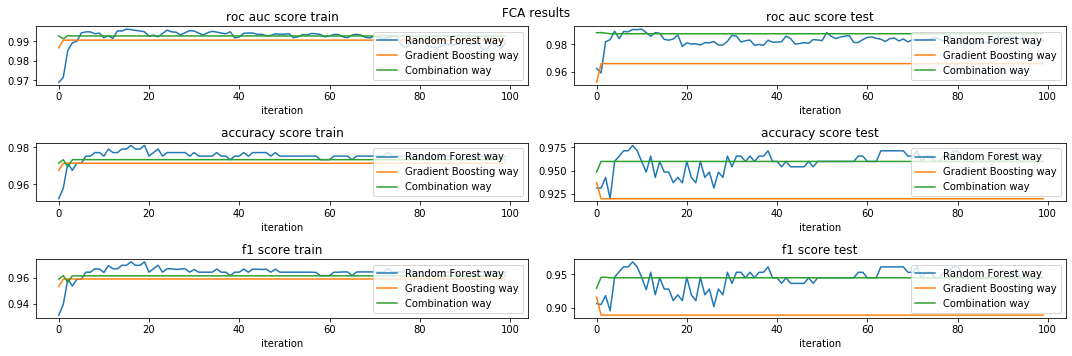

In [249]:
plt.figure(figsize=(15,5))
for idx, m in enumerate(['roc auc score', 'accuracy score','f1 score']):
    plt.subplot(3,2,2*idx+1)
    plt.plot(stats_rf_ds[f'{m} train'], label='Random Forest way')
    plt.plot(stats_gb_ds[f'{m} train'], label='Gradient Boosting way')
    plt.plot(stats_comb_ds[f'{m} train'], label='Combination way')
    plt.title(f"{m} train")
    plt.xlabel('iteration')
    plt.legend(loc='right')

    plt.subplot(3,2,2*idx+2)
    plt.plot(stats_rf_ds[f'{m} test'], label='Random Forest way')
    plt.plot(stats_gb_ds[f'{m} test'], label='Gradient Boosting way')
    plt.plot(stats_comb_ds[f'{m} test'], label='Combination way')
    plt.title(f"{m} test")
    plt.xlabel('iteration')
    plt.legend(loc='right')

plt.tight_layout()
plt.suptitle('FCA results')
plt.show()

# Production way

In [264]:
fcai = reload(fcai)

In [265]:
cntx_train = fcai.MultiValuedContext(X_train, objs=[str(x) for x in X_train.index], y_true=y_train, cat_attrs=cat_feats)
cntx_test = fcai.MultiValuedContext(X_test, objs=[str(x) for x in X_test.index], y_true=y_test, cat_attrs=cat_feats)
fm = fcai.FormalManager(cntx_train)

In [271]:
fm.construct_concepts(algo='GradientForest', rf_params={'n_estimators':5, 'max_depth':None}, n_layers=2)

In [272]:
preds = fm.predict_context(cntx_test).flatten()

In [273]:
roc_auc_score(y_test, preds)

0.989937641723356